In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
from module import Model_Training
import logging
tf.get_logger().setLevel(logging.ERROR)
Model_Training = Model_Training()


2023-04-01 00:25:41.673268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 00:25:42.671602: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-04-01 00:25:42.671696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LI

In [4]:
# full_img_path = '/mnt/d/Datasets/INbreast_COSINE/full/'
roi_img_path = '/mnt/d/Datasets/INbreast/ROI/CLAHE_multi_ROI/'
img_height = 224
img_width = 224
batch_size = 4
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
misclassified_store = '/mnt/c/Users/user/Desktop/INbreast_COSINE_misclassified/'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  class_names=['benign','malignant'],
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  class_names=['benign','malignant'],
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
train = train_ds.prefetch(AUTOTUNE)
val = val_ds.prefetch(AUTOTUNE)
# class_weight = {0:1,1:2}

Found 307 files belonging to 2 classes.
Found 79 files belonging to 2 classes.


In [6]:
test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  seed = 48,
  shuffle=None,
  batch_size=batch_size)

Found 98 files belonging to 2 classes.


Input = tf.inpu

In [8]:
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=0),
          tf.keras.metrics.AUC()]
weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_no_aug/'
model_inception = Model_Training.build_model('inceptionv3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,
                                   img_height=img_height,img_width=img_width,training=False)
model_inception.trainable = False
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_INbreast_COSINE/'
model_effnet = Model_Training.build_model('efficientnetb3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,
                                   img_height=img_height,img_width=img_width,training=False)
model_effnet.trainable = False
weights = '/home/jj/FYP/Checkpoint/Efficientnetv2m_INbreast_COSINE/'
model_effnetv2 = Model_Training.build_model('efficientnetv2m',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,
                                   img_height=img_height,img_width=img_width,training=False)
model_effnetv2.trainable = False
weights = '/home/jj/FYP/Checkpoint/Convnext_INbreast_COSINE/'
model_convnext = Model_Training.build_model('convnext',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,
                                   img_height=img_height,img_width=img_width,training=False)
model_convnext.trainable = False
# new_model = tf.keras.Sequential(model.layers[:-1])
input = tf.keras.layers.Input(shape=(img_height,img_width,3))
model_inception = tf.keras.models.Model(inputs=model_inception.input,outputs=model_inception.layers[-2].output)
model_convnext = tf.keras.models.Model(inputs=model_convnext.input,outputs=model_convnext.layers[-2].output)
model_effnet = tf.keras.models.Model(inputs=model_effnet.input,outputs=model_effnet.layers[-2].output)
model_effnetv2 = tf.keras.models.Model(inputs=model_effnetv2.input,outputs=model_effnetv2.layers[-2].output)
# model_inception.input()
inception_out = model_inception(input)
convnext_out = model_convnext(input)
effnet_out = model_effnet(input)
effnetv2_out = model_effnetv2(input)
merged = tf.keras.layers.Concatenate()([inception_out,convnext_out,effnet_out,effnetv2_out])
x = tf.keras.layers.Dense(1024,activation='relu')(merged)
output = tf.keras.layers.Dense(2,activation='softmax')(x)
ensemble = tf.keras.models.Model(inputs=input,outputs=output)
ensemble.summary()
ensemble.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=metric)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_7 (Functional)           (None, 1024)         26000160    ['input_15[0][0]']               
                                                                                                  
 model_8 (Functional)           (None, 1024)         90715264    ['input_15[0][0]']               
                                                                                                  
 model_9 (Functional)           (None, 1024)         14456623    ['input_15[0][0]']        

In [13]:
ensemble.fit(train,epochs=10,validation_data=val)

Epoch 1/10
77/77 [==============================] - 17s 219ms/step - loss: 0.1971 - categorical_accuracy: 0.9186 - precision_1: 0.8557 - recall_11: 0.9343 - auc_1: 0.9758 - val_loss: 0.6805 - val_categorical_accuracy: 0.8608 - val_precision_1: 0.7333 - val_recall_11: 0.8519 - val_auc_1: 0.8907
Epoch 2/10
77/77 [==============================] - 17s 223ms/step - loss: 0.1963 - categorical_accuracy: 0.9186 - precision_1: 0.8416 - recall_11: 0.9249 - auc_1: 0.9758 - val_loss: 0.5519 - val_categorical_accuracy: 0.8734 - val_precision_1: 0.7419 - val_recall_11: 0.8519 - val_auc_1: 0.9055
Epoch 3/10
77/77 [==============================] - 17s 224ms/step - loss: 0.1912 - categorical_accuracy: 0.9251 - precision_1: 0.8737 - recall_11: 0.9437 - auc_1: 0.9782 - val_loss: 0.6023 - val_categorical_accuracy: 0.8608 - val_precision_1: 0.7333 - val_recall_11: 0.8519 - val_auc_1: 0.9006
Epoch 4/10
77/77 [==============================] - 17s 224ms/step - loss: 0.1832 - categorical_accuracy: 0.9218 - 

25/25 [==============================] - 4s 170ms/step


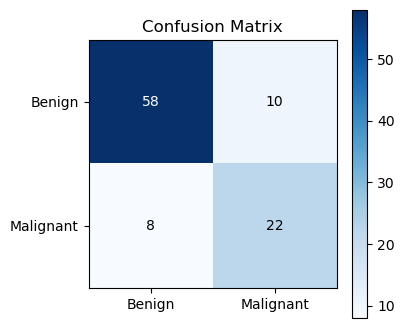

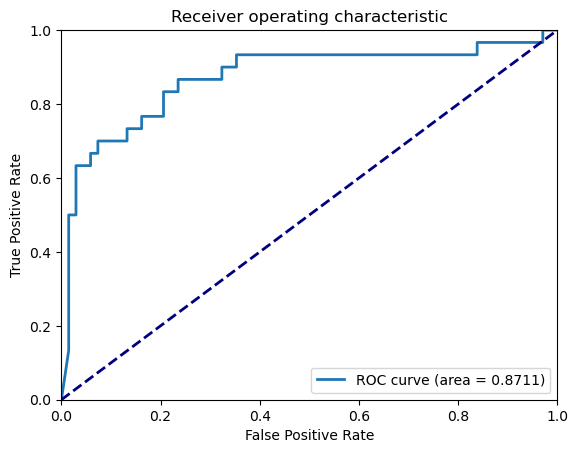

In [14]:
ensemble.evaluate(test)
prediction = ensemble.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)